In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 1. Create the fred Object

In [60]:
from fredapi import Fred

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get API key from environment variable
fred_key = os.getenv('FRED_API_KEY')

# Create FRED instance
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [61]:
sp_search = fred.search('S&P', order_by='popularity')

In [62]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2025-05-26,2025-05-26,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2025-05-22,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-05-23 08:36:10-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2025-05-26,2025-05-26,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2025-02-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2025-04-29 08:11:17-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2025-05-26,2025-05-26,S&P 500,2015-05-26,2025-05-23,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2025-05-23 19:11:34-05:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2025-05-26,2025-05-26,ICE BofA US High Yield Index Effective Yield,1996-12-31,2025-05-22,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-05-23 08:36:13-05:00,82,This data represents the effective yield of th...
BAMLC0A0CM,BAMLC0A0CM,2025-05-26,2025-05-26,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2025-05-22,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-05-23 08:49:02-05:00,78,The ICE BofA Option-Adjusted Spreads (OASs) ar...


# 3. Pull Raw Data & Plot

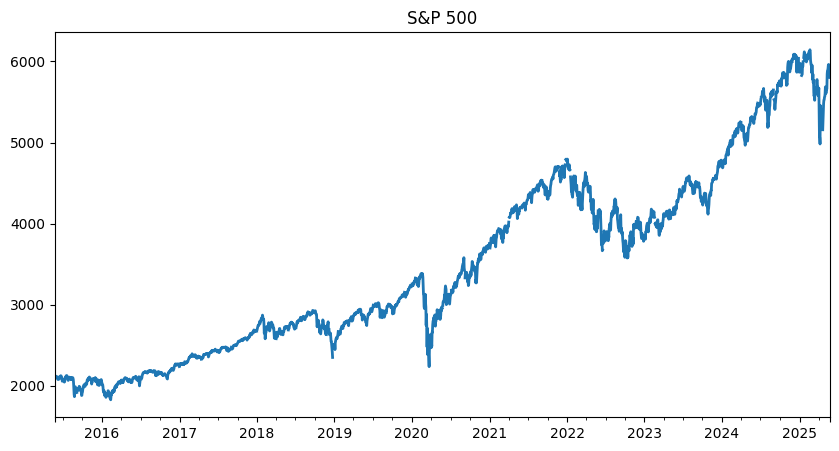

In [63]:
# import plt to identify the plt
import matplotlib.pyplot as plt

# Fetching the S&P 500 index data
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [64]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [65]:
import time  # required to use time.sleep
import pandas as pd

all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)  # Don't request too fast and get blocked

uemp_results = pd.concat(all_results, axis=1)

In [66]:
cols_to_drop = []

for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)

uemp_results = uemp_results.drop(columns=cols_to_drop, axis=1)

In [67]:
# Check if 'UNRATE' exists before dropping
if 'UNRATE' in uemp_results.columns:
    uemp_states = uemp_results.copy().drop('UNRATE', axis=1)
else:
    uemp_states = uemp_results.copy()

uemp_states = uemp_states.dropna()

id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
uemp_states.columns = [id_to_state.get(c, c) for c in uemp_states.columns]

In [68]:

# Plot States Unemployment Rate
px.line(uemp_states)


![S&P 500 Plot](newplot.png)

## Pull April 2020 Unemployment Rate Per State

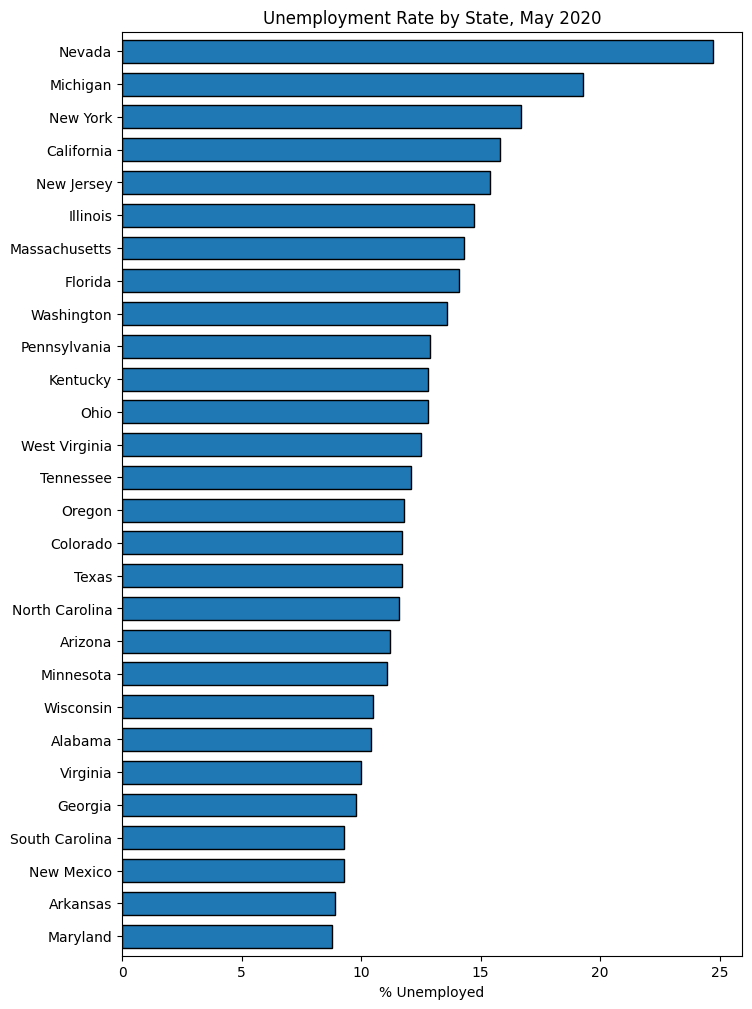

In [69]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

## Pull Participation Rate

In [70]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [71]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## Plot Unemployment vs Participation for each state!

In [72]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

In [ ]:
# Calculate number of states for subplot grid
n_states = len(uemp_states.columns)
n_rows = (n_states + 4) // 5  # 5 columns, calculate needed rows

fig, axs = plt.subplots(n_rows, 5, figsize=(30, 6*n_rows), sharex=True)
axs = axs.flatten()

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, state in enumerate(uemp_states.columns):
    ax2 = axs[i].twinx()
    
    # Plot unemployment rate
    uemp_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment', color=color_pal[0])
    
    # Plot participation rate
    part_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    
    ax2.grid(False)
    axs[i].set_title(state)
    
    # Add legend to first plot only
    if i == 0:
        lines1, labels1 = axs[i].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Hide empty subplots
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()